### 作業目的: 實作word2vec Skip-gram模型
在課程中了解如何搭建CBOW模型，這次的作業目的在於透過搭建Skip-gram模型來了解另外一種word2vec的架構。

- Hint_1: 學員可以善用課程中以搭建好的function模組
- Hint_2: Skip_gram所需的輸入資料與目標跟CBOW有些許不同，Skip_gram是由中間字詞預測上下文

In [1]:
# import modules
import numpy as np
from typing import List
from utils.utility import preprocess, convert_one_hot, Trainer
from utils.layers import Dense, SoftmaxWithCrossEntropy
from utils.optimizer import SGD

In [2]:
# use the same corpus as in the lecture
text = "I am studying Natural Language Processing now."

# define create_contexts_target function
def create_contexts_target(corpus: List, window_size: int=1):
    contexts = corpus[window_size:-window_size]
    targets = []
    for idx in range(window_size, len(corpus) - window_size):
        indices = list(range(idx - window_size, idx + window_size + 1))
        indices.remove(idx)
        ts = [corpus[i] for i in indices]
        targets.append(ts)

    return np.array(contexts), np.array(targets)

# transform corpus to contexts and targets pair
corpus, word2idx, idx2word = preprocess([text])
contexts, targets = create_contexts_target(corpus[0], window_size=1)
contexts, targets

(array([2, 4, 7, 5, 3, 1]),
 array([[6, 4],
        [2, 7],
        [4, 5],
        [7, 3],
        [5, 1],
        [3, 0]]))

In [3]:
# transform contexts and targets to one-hot encoding
contexts = convert_one_hot(contexts, len(word2idx))
targets = convert_one_hot(targets, len(word2idx))
contexts, targets

(array([[0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0]], dtype=int32),
 array([[[0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 1, 0, 0, 0]],
 
        [[0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1]],
 
        [[0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 1, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 1, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0]]], dtype=int32))

In [4]:
# define Skip-gram model
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size):
        V, H = vocab_size, hidden_size
        self.window_size = window_size

        # initialize weights
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # create layers
        self.in_layer = Dense(W_in)
        self.out_layer = Dense(W_out)
        self.loss_layers = [SoftmaxWithCrossEntropy() for i in range(window_size * 2)]

        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector matrix
        self.word_vecs = W_in

    def forward(self, contexts, targets):
        h = self.in_layer.forward(contexts)
        s = self.out_layer.forward(h)
        loss = sum([self.loss_layers[i].forward(s, targets[:, i]) for i in range(self.window_size * 2)])
        
        return loss

    def backward(self, dout=1):
        ds = sum([self.loss_layers[i].backward(dout) for i in range(self.window_size * 2)])
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        
        return None

In [5]:
# start training

# configurations
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# define model
skip_gram = SkipGram(len(word2idx), hidden_size, window_size)
sgd_optimizer = SGD()
trainer = Trainer(skip_gram, sgd_optimizer)

# start training
trainer.fit(contexts, targets, max_epoch, batch_size)

  7%|▋         | 68/1000 [00:00<00:01, 553.46it/s]

Epoch: 1, Iteration: 1/2, Loss: 4.15902006113147
Epoch: 2, Iteration: 1/2, Loss: 4.158985790837521
Epoch: 3, Iteration: 1/2, Loss: 4.158864833741857
Epoch: 4, Iteration: 1/2, Loss: 4.158934088690577
Epoch: 5, Iteration: 1/2, Loss: 4.158790673927234
Epoch: 6, Iteration: 1/2, Loss: 4.15870708355577
Epoch: 7, Iteration: 1/2, Loss: 4.158745564506209
Epoch: 8, Iteration: 1/2, Loss: 4.158600746404954
Epoch: 9, Iteration: 1/2, Loss: 4.158537632323334
Epoch: 10, Iteration: 1/2, Loss: 4.158520006715241
Epoch: 11, Iteration: 1/2, Loss: 4.158596915743298
Epoch: 12, Iteration: 1/2, Loss: 4.158333294910063
Epoch: 13, Iteration: 1/2, Loss: 4.158284393221344
Epoch: 14, Iteration: 1/2, Loss: 4.158270511729063
Epoch: 15, Iteration: 1/2, Loss: 4.1582283137778004
Epoch: 16, Iteration: 1/2, Loss: 4.158196134676663
Epoch: 17, Iteration: 1/2, Loss: 4.157765247477214
Epoch: 18, Iteration: 1/2, Loss: 4.1580729121420035
Epoch: 19, Iteration: 1/2, Loss: 4.1577046643812405
Epoch: 20, Iteration: 1/2, Loss: 4.1577

 12%|█▏        | 124/1000 [00:00<00:04, 193.80it/s]


Epoch: 112, Iteration: 1/2, Loss: 2.063341911948105
Epoch: 113, Iteration: 1/2, Loss: 1.979295937960584
Epoch: 114, Iteration: 1/2, Loss: 1.9798556611006042
Epoch: 115, Iteration: 1/2, Loss: 1.9927882157635746
Epoch: 116, Iteration: 1/2, Loss: 1.9080823123661788
Epoch: 117, Iteration: 1/2, Loss: 1.9213157610055345
Epoch: 118, Iteration: 1/2, Loss: 1.9080167370227779
Epoch: 119, Iteration: 1/2, Loss: 1.865351243756976
Epoch: 120, Iteration: 1/2, Loss: 1.8221881033392648
Epoch: 121, Iteration: 1/2, Loss: 1.8673281040160026
Epoch: 122, Iteration: 1/2, Loss: 1.7978652956623207
Epoch: 123, Iteration: 1/2, Loss: 1.8208556676098782
Epoch: 124, Iteration: 1/2, Loss: 1.752591410939968
Epoch: 125, Iteration: 1/2, Loss: 1.7717852952556523
Epoch: 126, Iteration: 1/2, Loss: 1.7536893221334366
Epoch: 127, Iteration: 1/2, Loss: 1.7798946474573654
Epoch: 128, Iteration: 1/2, Loss: 1.6864772759200597
Epoch: 129, Iteration: 1/2, Loss: 1.7895209057496761
Epoch: 130, Iteration: 1/2, Loss: 1.6639868418140

 19%|█▉        | 192/1000 [00:00<00:03, 203.02it/s]


Epoch: 135, Iteration: 1/2, Loss: 1.7042011225194087
Epoch: 136, Iteration: 1/2, Loss: 1.6238805547941786
Epoch: 137, Iteration: 1/2, Loss: 1.6310098265307302
Epoch: 138, Iteration: 1/2, Loss: 1.6557846604900566
Epoch: 139, Iteration: 1/2, Loss: 1.6302508713796169
Epoch: 140, Iteration: 1/2, Loss: 1.6280724888740423
Epoch: 141, Iteration: 1/2, Loss: 1.5827958374405056
Epoch: 142, Iteration: 1/2, Loss: 1.6028736172783549
Epoch: 143, Iteration: 1/2, Loss: 1.6096673584911423
Epoch: 144, Iteration: 1/2, Loss: 1.6080696549728097
Epoch: 145, Iteration: 1/2, Loss: 1.613108983540776
Epoch: 146, Iteration: 1/2, Loss: 1.5593194981924863
Epoch: 147, Iteration: 1/2, Loss: 1.5906977734625647
Epoch: 148, Iteration: 1/2, Loss: 1.5673464663015735
Epoch: 149, Iteration: 1/2, Loss: 1.5925825470903359
Epoch: 150, Iteration: 1/2, Loss: 1.5578761223696505
Epoch: 151, Iteration: 1/2, Loss: 1.5442749833297746
Epoch: 152, Iteration: 1/2, Loss: 1.5551222204754402
Epoch: 153, Iteration: 1/2, Loss: 1.5501923532

 28%|██▊       | 282/1000 [00:01<00:02, 302.06it/s]

Epoch: 195, Iteration: 1/2, Loss: 1.4593527974184664
Epoch: 196, Iteration: 1/2, Loss: 1.4500476753508815
Epoch: 197, Iteration: 1/2, Loss: 1.4600512800555108
Epoch: 198, Iteration: 1/2, Loss: 1.4478081470903161
Epoch: 199, Iteration: 1/2, Loss: 1.4623103381902394
Epoch: 200, Iteration: 1/2, Loss: 1.4561537265671984
Epoch: 201, Iteration: 1/2, Loss: 1.4530226544473104
Epoch: 202, Iteration: 1/2, Loss: 1.452143783205833
Epoch: 203, Iteration: 1/2, Loss: 1.452336519884248
Epoch: 204, Iteration: 1/2, Loss: 1.4450199068117255
Epoch: 205, Iteration: 1/2, Loss: 1.4568608236924259
Epoch: 206, Iteration: 1/2, Loss: 1.4472112765536935
Epoch: 207, Iteration: 1/2, Loss: 1.4495188836199346
Epoch: 208, Iteration: 1/2, Loss: 1.4422539557470209
Epoch: 209, Iteration: 1/2, Loss: 1.4455454132361636
Epoch: 210, Iteration: 1/2, Loss: 1.4524614581712236
Epoch: 211, Iteration: 1/2, Loss: 1.4509342272820605
Epoch: 212, Iteration: 1/2, Loss: 1.4389346505784977
Epoch: 213, Iteration: 1/2, Loss: 1.443909451545

 32%|███▏      | 321/1000 [00:01<00:02, 267.24it/s]

Epoch: 285, Iteration: 1/2, Loss: 1.4108544256927509
Epoch: 286, Iteration: 1/2, Loss: 1.4169294413509195
Epoch: 287, Iteration: 1/2, Loss: 1.4173673777322202
Epoch: 288, Iteration: 1/2, Loss: 1.4121132061958226
Epoch: 289, Iteration: 1/2, Loss: 1.4162902691114474
Epoch: 290, Iteration: 1/2, Loss: 1.4119372289812557
Epoch: 291, Iteration: 1/2, Loss: 1.4141736624211183
Epoch: 292, Iteration: 1/2, Loss: 1.4133831545312794
Epoch: 293, Iteration: 1/2, Loss: 1.4155301741530772
Epoch: 294, Iteration: 1/2, Loss: 1.4131093609490608
Epoch: 295, Iteration: 1/2, Loss: 1.4090360443660832
Epoch: 296, Iteration: 1/2, Loss: 1.417128959751878
Epoch: 297, Iteration: 1/2, Loss: 1.4104464257247624
Epoch: 298, Iteration: 1/2, Loss: 1.4125532542560157
Epoch: 299, Iteration: 1/2, Loss: 1.4123724754214626
Epoch: 300, Iteration: 1/2, Loss: 1.412561163355328
Epoch: 301, Iteration: 1/2, Loss: 1.409824057616584
Epoch: 302, Iteration: 1/2, Loss: 1.4156749999603782
Epoch: 303, Iteration: 1/2, Loss: 1.4118177129411

 42%|████▏     | 424/1000 [00:01<00:01, 368.34it/s]


Epoch: 353, Iteration: 1/2, Loss: 1.4052557936537067
Epoch: 354, Iteration: 1/2, Loss: 1.4064028708437921
Epoch: 355, Iteration: 1/2, Loss: 1.4034714744822052
Epoch: 356, Iteration: 1/2, Loss: 1.4061142596503777
Epoch: 357, Iteration: 1/2, Loss: 1.4048608685084965
Epoch: 358, Iteration: 1/2, Loss: 1.4047994000841273
Epoch: 359, Iteration: 1/2, Loss: 1.4058003823134086
Epoch: 360, Iteration: 1/2, Loss: 1.4027464076431126
Epoch: 361, Iteration: 1/2, Loss: 1.4058734558200425
Epoch: 362, Iteration: 1/2, Loss: 1.4027525074827407
Epoch: 363, Iteration: 1/2, Loss: 1.4058347601572498
Epoch: 364, Iteration: 1/2, Loss: 1.4039115056527987
Epoch: 365, Iteration: 1/2, Loss: 1.4041499887635327
Epoch: 366, Iteration: 1/2, Loss: 1.401039289635714
Epoch: 367, Iteration: 1/2, Loss: 1.4051957316389565
Epoch: 368, Iteration: 1/2, Loss: 1.4037082344249667
Epoch: 369, Iteration: 1/2, Loss: 1.4036424053671972
Epoch: 370, Iteration: 1/2, Loss: 1.4022314682813537
Epoch: 371, Iteration: 1/2, Loss: 1.4049048027

 47%|████▋     | 467/1000 [00:01<00:01, 272.02it/s]

Epoch: 426, Iteration: 1/2, Loss: 1.3990508360286764
Epoch: 427, Iteration: 1/2, Loss: 1.3997140329896465
Epoch: 428, Iteration: 1/2, Loss: 1.3985945035453153
Epoch: 429, Iteration: 1/2, Loss: 1.4003272375871765
Epoch: 430, Iteration: 1/2, Loss: 1.3997458577747073
Epoch: 431, Iteration: 1/2, Loss: 1.3993718640481547
Epoch: 432, Iteration: 1/2, Loss: 1.399530061607374
Epoch: 433, Iteration: 1/2, Loss: 1.399243106147619
Epoch: 434, Iteration: 1/2, Loss: 1.3984976134486513
Epoch: 435, Iteration: 1/2, Loss: 1.4010007153320136
Epoch: 436, Iteration: 1/2, Loss: 1.398242629141877
Epoch: 437, Iteration: 1/2, Loss: 1.398332208326595
Epoch: 438, Iteration: 1/2, Loss: 1.400247292412448
Epoch: 439, Iteration: 1/2, Loss: 1.3980582507450252
Epoch: 440, Iteration: 1/2, Loss: 1.3999579238226956
Epoch: 441, Iteration: 1/2, Loss: 1.3988229136366774
Epoch: 442, Iteration: 1/2, Loss: 1.3990275401765895
Epoch: 443, Iteration: 1/2, Loss: 1.3988234121288707
Epoch: 444, Iteration: 1/2, Loss: 1.398042702372963

 50%|█████     | 502/1000 [00:01<00:02, 243.30it/s]

Epoch: 468, Iteration: 1/2, Loss: 1.3991901805544977
Epoch: 469, Iteration: 1/2, Loss: 1.3970539760502003
Epoch: 470, Iteration: 1/2, Loss: 1.3977555001006383
Epoch: 471, Iteration: 1/2, Loss: 1.3975902016483852
Epoch: 472, Iteration: 1/2, Loss: 1.397519452105915
Epoch: 473, Iteration: 1/2, Loss: 1.3976006449775176
Epoch: 474, Iteration: 1/2, Loss: 1.3968197945903347
Epoch: 475, Iteration: 1/2, Loss: 1.3981672029159706
Epoch: 476, Iteration: 1/2, Loss: 1.3975880783126136
Epoch: 477, Iteration: 1/2, Loss: 1.3981652968751344
Epoch: 478, Iteration: 1/2, Loss: 1.396505977954807
Epoch: 479, Iteration: 1/2, Loss: 1.3973862605790652
Epoch: 480, Iteration: 1/2, Loss: 1.3973059970548523
Epoch: 481, Iteration: 1/2, Loss: 1.3971561676312287
Epoch: 482, Iteration: 1/2, Loss: 1.397424526031254
Epoch: 483, Iteration: 1/2, Loss: 1.397233173690757
Epoch: 484, Iteration: 1/2, Loss: 1.3970716539015382
Epoch: 485, Iteration: 1/2, Loss: 1.3971648121529385
Epoch: 486, Iteration: 1/2, Loss: 1.39712297689404

 64%|██████▎   | 637/1000 [00:02<00:01, 317.69it/s]

Epoch: 515, Iteration: 1/2, Loss: 1.396070845513386
Epoch: 516, Iteration: 1/2, Loss: 1.3962665641497858
Epoch: 517, Iteration: 1/2, Loss: 1.3965651208314438
Epoch: 518, Iteration: 1/2, Loss: 1.396027604313855
Epoch: 519, Iteration: 1/2, Loss: 1.3947204420986457
Epoch: 520, Iteration: 1/2, Loss: 1.3965686706246707
Epoch: 521, Iteration: 1/2, Loss: 1.395939940490926
Epoch: 522, Iteration: 1/2, Loss: 1.3959415809044304
Epoch: 523, Iteration: 1/2, Loss: 1.3958963571234837
Epoch: 524, Iteration: 1/2, Loss: 1.3958738353185656
Epoch: 525, Iteration: 1/2, Loss: 1.3959505889127555
Epoch: 526, Iteration: 1/2, Loss: 1.395628568841179
Epoch: 527, Iteration: 1/2, Loss: 1.395930825861846
Epoch: 528, Iteration: 1/2, Loss: 1.3955724012830517
Epoch: 529, Iteration: 1/2, Loss: 1.3952246338477114
Epoch: 530, Iteration: 1/2, Loss: 1.3962370488551263
Epoch: 531, Iteration: 1/2, Loss: 1.3957174623262838
Epoch: 532, Iteration: 1/2, Loss: 1.3955032120102764
Epoch: 533, Iteration: 1/2, Loss: 1.395597540664147

 84%|████████▍ | 845/1000 [00:02<00:00, 582.94it/s]


Epoch: 678, Iteration: 1/2, Loss: 1.3928611125197898
Epoch: 679, Iteration: 1/2, Loss: 1.3922989267500567
Epoch: 680, Iteration: 1/2, Loss: 1.3935031357585852
Epoch: 681, Iteration: 1/2, Loss: 1.3922797371783346
Epoch: 682, Iteration: 1/2, Loss: 1.392312882259201
Epoch: 683, Iteration: 1/2, Loss: 1.3933940433629048
Epoch: 684, Iteration: 1/2, Loss: 1.3926782422909083
Epoch: 685, Iteration: 1/2, Loss: 1.3923420311707158
Epoch: 686, Iteration: 1/2, Loss: 1.392905043317731
Epoch: 687, Iteration: 1/2, Loss: 1.392316509533614
Epoch: 688, Iteration: 1/2, Loss: 1.3921853010448955
Epoch: 689, Iteration: 1/2, Loss: 1.3926246220142262
Epoch: 690, Iteration: 1/2, Loss: 1.392837019369977
Epoch: 691, Iteration: 1/2, Loss: 1.3926291075566324
Epoch: 692, Iteration: 1/2, Loss: 1.392148998749935
Epoch: 693, Iteration: 1/2, Loss: 1.392902293712321
Epoch: 694, Iteration: 1/2, Loss: 1.3925543015457538
Epoch: 695, Iteration: 1/2, Loss: 1.3929104060700994
Epoch: 696, Iteration: 1/2, Loss: 1.392099385452335

100%|██████████| 1000/1000 [00:02<00:00, 358.73it/s]


Epoch: 886, Iteration: 1/2, Loss: 1.3906967399992558
Epoch: 887, Iteration: 1/2, Loss: 1.3906876464819915
Epoch: 888, Iteration: 1/2, Loss: 1.3906407765893747
Epoch: 889, Iteration: 1/2, Loss: 1.3907043858315848
Epoch: 890, Iteration: 1/2, Loss: 1.3906272864823377
Epoch: 891, Iteration: 1/2, Loss: 1.390690577716771
Epoch: 892, Iteration: 1/2, Loss: 1.3906415535980226
Epoch: 893, Iteration: 1/2, Loss: 1.3906599925693262
Epoch: 894, Iteration: 1/2, Loss: 1.390854640885439
Epoch: 895, Iteration: 1/2, Loss: 1.3903918069853538
Epoch: 896, Iteration: 1/2, Loss: 1.390388416378433
Epoch: 897, Iteration: 1/2, Loss: 1.3910846704502893
Epoch: 898, Iteration: 1/2, Loss: 1.3903580166053202
Epoch: 899, Iteration: 1/2, Loss: 1.390384732795792
Epoch: 900, Iteration: 1/2, Loss: 1.3908127923048776
Epoch: 901, Iteration: 1/2, Loss: 1.39086052651732
Epoch: 902, Iteration: 1/2, Loss: 1.3900714568078139
Epoch: 903, Iteration: 1/2, Loss: 1.3906165036998572
Epoch: 904, Iteration: 1/2, Loss: 1.390789038435871

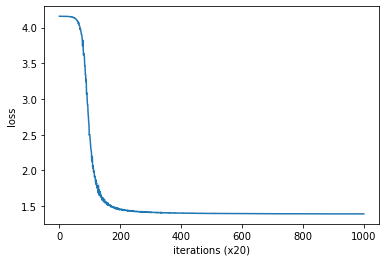

In [6]:
trainer.plot()

In [7]:
# check skip-gram results
word_vecs = skip_gram.word_vecs
for word_id, word in idx2word.items():
    print(word, word_vecs[word_id])

. [ 0.00540129  0.00416394  0.00725283 -0.00497087  0.01710908]
now [ 0.15975429 -1.9225913   0.41327745 -0.7595175  -1.9016107 ]
am [-1.3899754  -0.02556935  1.9042108  -1.018543    1.2759961 ]
processing [ 2.222649    1.4994948  -0.76909554 -0.0632517  -0.45858148]
studying [-0.8803772   0.25252277 -1.4196982   1.8034607   1.4257361 ]
language [-0.92387885 -1.8610517  -1.3427458   1.5364372  -1.003436  ]
i [-0.00539189 -0.00331921  0.00413546 -0.0157114   0.00840823]
natural [ 0.44818872  2.3492718   1.2361885  -1.4921843   0.3150651 ]
